# scCODA - Modeling options and result analysis

This tutorial notebook serves as an extension to the general tutorial and presents ways to alternate the model and perform more in-depth result analysis and diagnostics.
We will focus on:

- Modifications of the model formula and reference cell type to perform different modeling tasks
- Plotting of compositional data and scCODA results
- Inference methods available in scCODA
- Advanced interpretation and analysis of results
- Alternative differential abundance testing using all references

We will again analyze the small intestinal epithelium data of mice from [Haber et al., 2017](https://www.nature.com/articles/nature24489).
First, we read in the data and perform the same preprocessing steps as in the general tutorial:

In [1]:
import warnings

warnings.filterwarnings("ignore")

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pertpy as pt

MuData object with n_obs × n_vars = 9852 × 15223
  3 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label'
    coda:	10 x 8
      obs:	'condition'
      var:	'n_cells'
    coda_salm:	6 x 8
      obs:	'condition'
      var:	'n_cells'


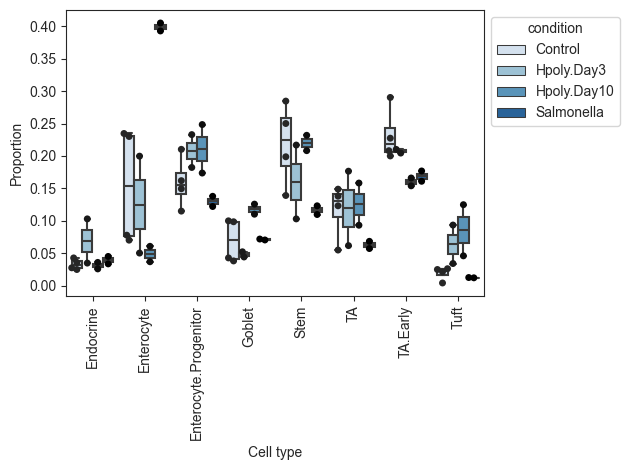

In [2]:
# Load data
haber_cells = pt.dt.haber_2017_regions()

# Convert data to mudata object
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    haber_cells,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cell_label",
    sample_identifier="batch",
    covariate_obs=["condition"],
)

# Select control and salmonella data as one modality
sccoda_data.mod["coda_salm"] = sccoda_data["coda"][
    sccoda_data["coda"].obs["condition"].isin(["Control", "Salmonella"])
].copy()
print(sccoda_data)

# plot boxplots
pt.pl.coda.boxplots(sccoda_data, modality_key="coda", feature_name="condition", add_dots=True)
plt.show()

Alternatively, we can also plot the data as stacked barplots:

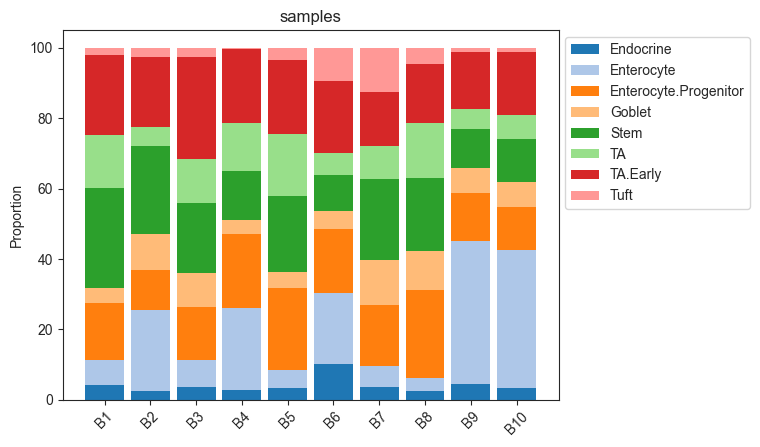

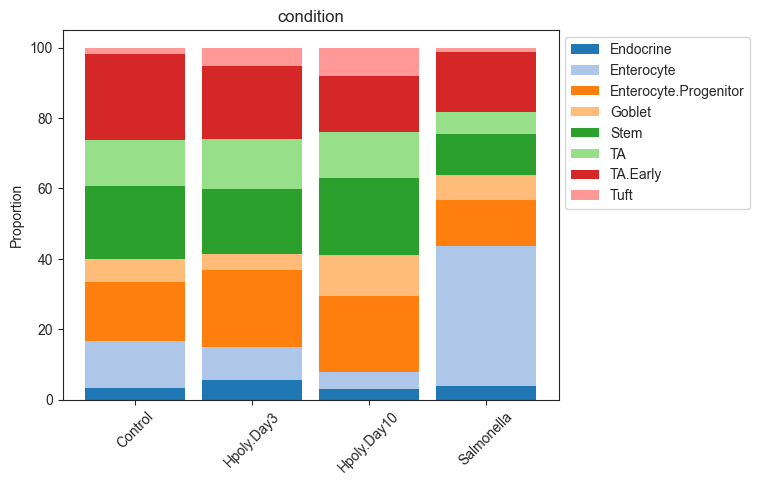

In [3]:
# Stacked barplot for each sample
pt.pl.coda.stacked_barplot(sccoda_data, modality_key="coda", feature_name="samples")
plt.show()

# Stacked barplot for the levels of "Condition"
pt.pl.coda.stacked_barplot(sccoda_data, modality_key="coda", feature_name="condition")
plt.show()

## Tweaking the model formula and reference cell type

First, we take a closer look at how changing the `formula` parameter of the scCODA model influences the results.
Internally, the formula string is converted into a linear model-like design matrix via [patsy](https://patsy.readthedocs.io/en/latest/),
which has a similar syntax to the `lm` function in the R language.

### Multi-level categories

Patsy allows us to automatically handle categorical covariates, even with multiple levels.
For example, we can model the effect of all three diseases at once, using the `coda` data modality, which contains all 10 samples:

In [4]:
# model all three diseases at once
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="condition",
    reference_cell_type="Endocrine",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda")
sccoda_model.summary(sccoda_data, modality_key="coda")

sample: 100%|██████████| 11000/11000 [01:05<00:00, 166.83it/s, 127 steps of size 2.09e-02. acc. prob=0.75]


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 10 samples, 8 cell types                                    │
│ Reference cell type                         │ Endocrine                                                         │
│ Formula                                     │ condition                                                         │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                        Final Parameter  Expected Sample                                                         │
│ Cell Type                                                                                                       │
│ Endocrine                  0.970            46.752                                                              │
│ Enterocyte                 1.893           117.666                                                              │
│ Enterocyte.Progenitor      2.328           181.790                                                              │
│ Goblet                     1.458            76.161                                                              │
│ Stem                       2.399           195.166                                                              │
│ TA                         1.857           113.505                                                              │
│ TA.Early                   2.519           220.049                                                              │
│ Tuft                       0.625            33.111                                                              │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                               Final Parameter  Expected Sample  log2-fold change                │
│ Covariate              Cell Type                                                                                │
│ conditionT.Hpoly.Day3  Endocrine                  0.000            46.752             0.000                     │
│                        Enterocyte                 0.000           117.666             0.000                     │
│                        Enterocyte.Progenitor      0.000           181.790             0.000                     │
│                        Goblet                     0.000            76.161             0.000                     │
│                        Stem                       0.000           195.166             0.000                     │
│                        TA                         0.000           113.505             0.000                     │
│                        TA.Early                   0.000           220.049             0.000                     │
│                        Tuft                       0.000            33.111             0.000                     │
│ conditionT.Hpoly.Day10 Endocrine                  0.000            46.752             0.000                     │
│                        Enterocyte                 0.000           117.666             0.000                     │
│                        Enterocyte.Progenitor      0.000           181.790             0.000                     │
│                        Goblet                     0.000            76.161             0.000                     │
│                        Stem                       0.000           195.166             0.000                     │
│                        TA                         0.000           113.505             0.000                     │
│                        TA.Early                   0.000           220.049             0.000                     │
│                        Tuft                       0.000            33.111             0.000                     │
│ conditionT.Salmonella  Endocrine                  0.000            32.433            -0.528                     │
│                        Enterocyte                 1.546           383.065             1.703                     │
│                        Enterocyte.Progenitor      0.000           126.112            -0.528                     │
│                        Goblet                     0.000            52.835            -0.528                     │
│                        Stem                       0.000           135.391            -0.528                     │
│                        TA                         0.000            78.741            -0.528                     │
│                        TA.Early                   0.000           152.653            -0.528                     │
│                        Tuft                       0.000            22.970            -0.528                     │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

### Different reference levels

Per default, categorical variables are encoded via full-rank treatment coding. Hereby, the value of the first sample in the dataset is used as the default (control) category.
We can select the default level by changing the model formula to `"C(<CovariateName>, Treatment('<ReferenceLevelName>'))"`:

For example, we can switch the salmonella model to test diseased versus healthy samples, which switches the sign of the only credible effect (Enterocytes).

In [22]:
# Set salmonella infection as "default" category

sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda_salm",
    formula="C(condition, Treatment('Salmonella'))",
    reference_cell_type="Goblet",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda_salm")
sccoda_model.summary(sccoda_data, modality_key="coda_salm")

sample: 100%|██████████| 11000/11000 [00:47<00:00, 230.14it/s, 255 steps of size 1.80e-02. acc. prob=0.86]


                                          Compositional Analysis summary                                           
┌────────────────────────────────────────┬────────────────────────────────────────────────────────────────────────┐
│ Name                                   │ Value                                                                  │
├────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────┤
│ Data                                   │ Data: 6 samples, 8 cell types                                          │
│ Reference cell type                    │ Goblet                                                                 │
│ Formula                                │ C(condition, Treatment('Salmonella'))                                  │
└────────────────────────────────────────┴────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                        Final Parameter  Expected Sample                                                         │
│ Cell Type                                                                                                       │
│ Endocrine                  1.229            28.334                                                              │
│ Enterocyte                 3.670           325.399                                                              │
│ Enterocyte.Progenitor      2.541           105.220                                                              │
│ Goblet                     1.746            47.515                                                              │
│ Stem                       2.594           110.947                                                              │
│ TA                         2.009            61.809                                                              │
│ TA.Early                   2.849           143.173                                                              │
│ Tuft                       0.419            12.604                                                              │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                       Final Parameter  Expected Sample          │
│ log2-fold change                                                                                                │
│ Covariate                                      Cell Type                                                        │
│ C(condition, Treatment('Salmonella'))T.Control Endocrine                   0.000           39.776               │
│ 0.489                                                                                                           │
│                                                Enterocyte                 -1.340          119.591               │
│ -1.444                                                                                                          │
│                                                Enterocyte.Progenitor       0.000          147.714               │
│ 0.489                                                                                                           │
│                                                Goblet                      0.000           66.705               │
│ 0.489                                                                                                           │
│                                                Stem                        0.000          155.754               │
│ 0.489                                                                                                           │
│                                                TA                          0.000           86.771               │
│ 0.489                                                                                                           │
│                                                TA.Early                    0.000          200.994               │
│ 0.489                                                                                                           │
│                                                Tuft                        0.000           17.695               │
│ 0.489                                                                                                           │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

### Switching the reference cell type

Compositional analysis generally does not allow statements on absolute abundance changes, but only in relation to a reference category,
which is assumed to be unchanged in absolute abundance.
The reference cell type fixes this category in scCODA. Thus, an interpretation of scCODA's effects should always be formulated like:

"Using cell type xy as a reference, cell types (a, b, c) were found to credibly change in abundance"

Switching the reference cell type might thus produce different results.
For example, if we choose a different cell type as the reference (such as Enterocytes in the salmonella infection data),
scCODA can find other credible effects on the other cell types.

*Note: In this example we have to set the FDR very high, since all cell types except Enterocytes do not show big changes. FDR values of more than 0.2 are not recommended in practice*

In [23]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda_salm",
    formula="condition",
    reference_cell_type="Enterocyte",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda_salm")
sccoda_model.summary(sccoda_data, modality_key="coda_salm", est_fdr=0.4)

sample: 100%|██████████| 11000/11000 [00:32<00:00, 340.52it/s, 63 steps of size 6.98e-02. acc. prob=0.70]


                                          Compositional Analysis summary                                           
┌──────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┐
│ Name                                         │ Value                                                            │
├──────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────┤
│ Data                                         │ Data: 6 samples, 8 cell types                                    │
│ Reference cell type                          │ Enterocyte                                                       │
│ Formula                                      │ condition                                                        │
└──────────────────────────────────────────────┴──────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                        Final Parameter  Expected Sample                                                         │
│ Cell Type                                                                                                       │
│ Endocrine                   0.550           34.807                                                              │
│ Enterocyte                  2.075          159.941                                                              │
│ Enterocyte.Progenitor       1.861          129.128                                                              │
│ Goblet                      1.089           59.669                                                              │
│ Stem                        2.086          161.710                                                              │
│ TA                          1.472           87.515                                                              │
│ TA.Early                    2.211          183.242                                                              │
│ Tuft                       -0.056           18.988                                                              │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                Final Parameter  Expected Sample  log2-fold change               │
│ Covariate               Cell Type                                                                               │
│ condition[T.Salmonella] Endocrine                   0.000           41.619             0.258                    │
│                         Enterocyte                  0.000          191.246             0.258                    │
│                         Enterocyte.Progenitor       0.000          154.402             0.258                    │
│                         Goblet                      0.000           71.347             0.258                    │
│                         Stem                       -0.468          121.082            -0.417                    │
│                         TA                         -0.380           71.579            -0.290                    │
│                         TA.Early                   -0.308          161.019            -0.187                    │
│                         Tuft                        0.000           22.704             0.258                    │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

### Finding a reference cell type
The scCODA model requires a cell type to be set as the reference category. However, choosing this cell type is often difficult.
A good first choice is a referenece cell type that closely preserves the changes in relative abundance during the compositional analysis.

For this, it is important that the reference cell type is not rare, to avoid large relative changes being caused by small absolute changes.
Also, the relative abundance of the reference should vary as little as possible across all samples.

The visualization `rel_abundance_dispersion_plot` shows the presence (share of non-zero samples) over all samples for each cell type
versus its dispersion in relative abundance. Cell types that have a higher presence than a certain threshold (default 0.9) are suitable candidates for the reference and thus colored.


<AxesSubplot: xlabel='Presence', ylabel='Total dispersion'>

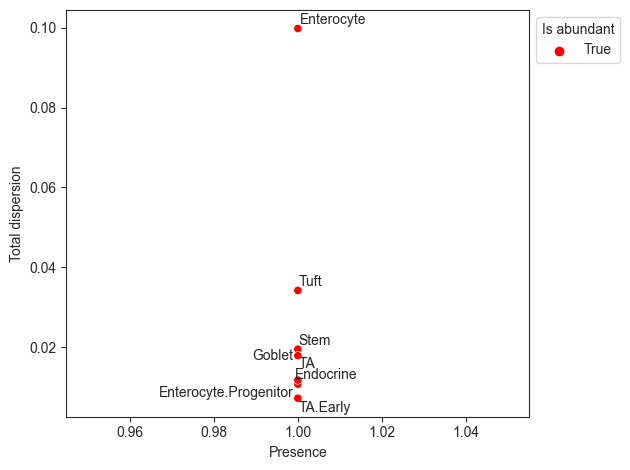

In [24]:
pt.pl.coda.rel_abundance_dispersion_plot(sccoda_data, modality_key="coda", abundant_threshold=0.9)

## Inference algorithms in scCODA

scCODA performs parameter inference via Markov-chain Monte Carlo (MCMC) methods.
There are three different MCMC sampling methods available for scCODA:

- HMC sampling with Dual-averaging step size adaptation ([Nesterov, 2009](https://link.springer.com/article/10.1007/s10107-007-0149-x)): `run_hmc()`
- No-U-Turn sampling ([Hoffman and Gelman, 2014](https://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf)): `run_nuts()`

Generally, it is recommended to use NUTS sampling. Other methods, such as variational inference, are in consideration.

For all MCMC sampling methods, properties such as the MCMC chain length and the number of burn-in samples are directly adjustable.

## Result analysis and diagnostics

The "getting started" tutorial explains how to do interpret the basic output of scCODA.
To follow this up, we now take a look at how MCMC diagnostics and more advanced result analysis in scCODA can be performed.

For this section, we again use the model of salmonella infection versus control group, with a reference cell type of Goblet cells.

In [25]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda_salm",
    formula="condition",
    reference_cell_type="Goblet",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda_salm")

sample: 100%|██████████| 11000/11000 [00:39<00:00, 275.96it/s, 255 steps of size 2.61e-02. acc. prob=0.82]


### Extended model summary

`sccoda_model.summary()` can give us, apart from the properties already explained in the basic tutorial, more information about the posterior inferred by the model by setting `extended=True`.
The extended summary also includes some information on the MCMC sampling procedure (chain length, burn-in, acceptance rate, duration).

For both effects and intercepts, we also get the standard deviation (SD) and high density interval endpoints of the posterior density of the generated Markov chain.

The effects summary also includes the spike-and-slab inclusion probability for each effect, i.e. the share of MCMC samples, for which this effect was not set to 0 by the spike-and-slab prior.
A threshold on this value serves as the deciding factor whether an effect is considered statistically credible

We can also use the summary tables from `summary()` as pandas DataFrames to tweak them further.
They are also accessible via `sccoda_model.get_intercept_df()` and `sccoda_model.get_effect_df()`, respectively.
Furthermore, the tables are generated through the `summary()` function in [arviz](https://arviz-devs.github.io/arviz/index.html) and support all its functionality.
This means that we can, for example, easily change the credible interval of parameters:

In [26]:
sccoda_model.summary(sccoda_data, modality_key="coda_salm", hdi_prob=0.8, extended=True)

                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 6 samples, 8 cell types                                           │
│ Reference cell type                   │ Goblet                                                                  │
│ Formula                               │ condition                                                               │
│ Reference index                       │ 3                                                                       │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ Spike-and-slab threshold              │ 1.000                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (1000 burnin samples)                        │
│ Acceptance rate                       │ 81.8%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                        Final Parameter  HDI 10%  HDI 90%   SD   Expected Sample                                 │
│ Cell Type                                                                                                       │
│ Endocrine                  1.118         0.699   1.590   0.357      34.667                                      │
│ Enterocyte                 2.329         1.961   2.741   0.310     116.372                                      │
│ Enterocyte.Progenitor      2.519         2.129   2.915   0.311     140.723                                      │
│ Goblet                     1.747         1.355   2.158   0.321      65.027                                      │
│ Stem                       2.703         2.335   3.101   0.304     169.152                                      │
│ TA                         2.109         1.705   2.532   0.326      93.391                                      │
│ TA.Early                   2.861         2.482   3.244   0.301     198.105                                      │
│ Tuft                       0.438        -0.036   0.946   0.394      17.563                                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                Final Parameter  Expected Sample  log2-fold change               │
│ Covariate               Cell Type                                                                               │
│ condition[T.Salmonella] Endocrine                  0.000            24.752            -0.486                    │
│                         Enterocyte                 1.354           321.913             1.468                    │
│                         Enterocyte.Progenitor      0.000           100.474            -0.486                    │
│                         Goblet                     0.000            46.428            -0.486                    │
│                         Stem                       0.000           120.771            -0.486                    │
│                         TA                         0.000            66.680            -0.486                    │
│                         TA.Early                   0.000           141.443            -0.486                    │
│                         Tuft                       0.000            12.540            -0.486                    │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                HDI 10%  HDI 90%   SD   Inclusion probability                    │
│ Covariate               Cell Type                                                                               │
│ condition[T.Salmonella] Endocrine              -0.136   0.848   0.319         0.452                             │
│                         Enterocyte              1.010   1.676   0.263         1.000                             │
│                         Enterocyte.Progenitor  -0.185   0.461   0.159         0.321                             │
│                         Goblet                  0.000   0.000   0.000         0.000                             │
│                         Stem                   -0.589   0.040   0.212         0.388                             │
│                         TA                     -0.613   0.134   0.232         0.385                             │
│                         TA.Early               -0.289   0.274   0.127         0.283                             │
│                         Tuft                   -0.506   0.658   0.308         0.398                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘


### Diagnostics and plotting

Similarly to the summary dataframes being compatible with [arviz](https://arviz-devs.github.io/arviz/index.html),
e can convert the result to an extension of arviz's `Inference Data` class via `make_arviz`. This means that we can use all its MCMC diagnostic and plotting functionality.
As an example, looking at the MCMC trace plots and kernel density estimates, we see that they are indicative of a well sampled MCMC chain:

Note: Due to the spike-and-slab priors, the `beta` parameters have many values at 0, which looks like a convergence issue, but is actually not.

**Caution: Trying to plot a kernel density estimate for an effect on the reference cell type results in an error, since it is constant at 0 for the entire chain.
To avoid this, add** `coords={"cell_type": salm_results.posterior.coords["cell_type_nb"]}` **as an argument to `az.plot_trace`, which causes the plots for the reference cell type to be skipped.**

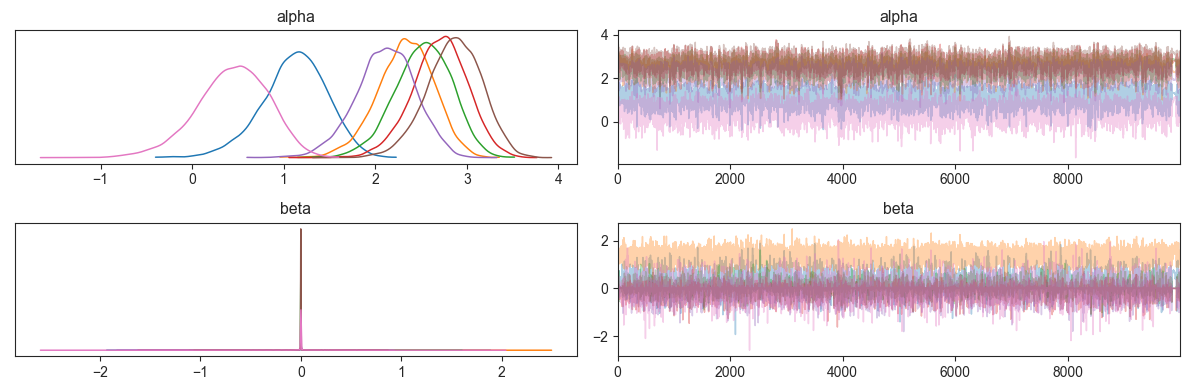

In [29]:
salm_arviz = sccoda_model.make_arviz(sccoda_data, modality_key="coda_salm")
az.plot_trace(
    salm_arviz,
    divergences=False,
    var_names=["alpha", "beta"],
    coords={"cell_type": salm_arviz.posterior.coords["cell_type_nb"]},
)
plt.tight_layout()
plt.show()

### Using all cell types as reference alternatively to reference selection

scCODA uses a reference cell type that is considered to be unchanged over the experiment to guarantee the unique identifiability of results.
If no such cell type is known beforehand, setting `reference_cell_type="automatic"` will find a suited reference.
Alternatively, it is possible to find credible effects on cell types that are mostly independent of the reference.
By sequentially running scCODA and selecting each cell type as the reference once, we can then use a majority vote to find the cell types that were credibly changing more than half of the time.

Below, an example code for this procedure on the Salmonella infection data shows that only Enterocytes were found to be credible more than half of the time.
Indeed, they are credibly changing for every reference cell type except themselves.
All other cell types were not found to change with any reference.

In [34]:
# Run scCODA with each cell type as the reference
cell_types = sccoda_data["coda_salm"].var.index
results_cycle = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    sccoda_data = sccoda_model.prepare(
        sccoda_data,
        modality_key="coda_salm",
        formula="condition",
        reference_cell_type=ct,
    )
    sccoda_model.run_nuts(sccoda_data, modality_key="coda_salm")

    # Select credible effects
    cred_eff = sccoda_model.credible_effects(sccoda_data, modality_key="coda_salm")
    cred_eff.index = cred_eff.index.droplevel(level=0)

    # add up credible effects
    results_cycle["times_credible"] += cred_eff.astype("int")

Reference: Endocrine


sample: 100%|██████████| 11000/11000 [00:41<00:00, 264.03it/s, 255 steps of size 2.40e-02. acc. prob=0.83]


Reference: Enterocyte


sample: 100%|██████████| 11000/11000 [00:29<00:00, 375.11it/s, 31 steps of size 9.02e-02. acc. prob=0.63]


Reference: Enterocyte.Progenitor


sample: 100%|██████████| 11000/11000 [00:41<00:00, 264.37it/s, 127 steps of size 2.26e-02. acc. prob=0.87]


Reference: Goblet


sample: 100%|██████████| 11000/11000 [00:37<00:00, 294.89it/s, 127 steps of size 2.88e-02. acc. prob=0.75]


Reference: Stem


sample: 100%|██████████| 11000/11000 [00:43<00:00, 254.13it/s, 127 steps of size 2.02e-02. acc. prob=0.87]


Reference: TA


sample: 100%|██████████| 11000/11000 [00:36<00:00, 301.89it/s, 127 steps of size 3.26e-02. acc. prob=0.71]


Reference: TA.Early


sample: 100%|██████████| 11000/11000 [00:38<00:00, 282.39it/s, 127 steps of size 2.59e-02. acc. prob=0.81]


Reference: Tuft


sample: 100%|██████████| 11000/11000 [00:46<00:00, 238.00it/s, 255 steps of size 1.76e-02. acc. prob=0.90]


In [35]:
# Calculate percentages
results_cycle["pct_credible"] = results_cycle["times_credible"] / len(cell_types)
results_cycle["is_credible"] = results_cycle["pct_credible"] > 0.5
print(results_cycle)

                       times_credible  pct_credible  is_credible
cell_label                                                      
Endocrine                           0         0.000        False
Enterocyte                          7         0.875         True
Enterocyte.Progenitor               0         0.000        False
Goblet                              0         0.000        False
Stem                                0         0.000        False
TA                                  0         0.000        False
TA.Early                            0         0.000        False
Tuft                                0         0.000        False
